In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# UTILS

In [2]:
def compute_class_weights(labels):
    unique, counts = np.unique(np.argmax(labels.numpy(), axis=1), return_counts=True)
    class_weights = torch.tensor([(class_counts / labels.shape[0]) for class_counts in counts],dtype=torch.float32)
    return class_weights

In [3]:
def compute_min_max(data_path):
    data = np.loadtxt(data_path, delimiter=",", dtype=np.float32, skiprows=1)[:, 1:-7]
    return np.stack((data.min(axis=0), data.max(axis=0)))

In [4]:
class CovidDataset(Dataset): 
    def __init__(self, path, label_num):
        self.data = np.loadtxt(path, delimiter=",", dtype=np.float32, skiprows=1)
        self.x = torch.from_numpy(self.data[:, 1:-7])
        
        print(self.x.shape)
        #print("data", pd.get_dummies(self.data[:, -1]))
        y = pd.get_dummies(self.data[:, label_num]).to_numpy(dtype=np.float32)
        #print("y == ", y)
        self.y = torch.from_numpy(y)

        self.minMax = torch.from_numpy(compute_min_max(path))#, split_indexes[0], split_indexes[1]))
        self.len = len(self.data)
        self.class_weights = compute_class_weights(self.y)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        inputs = torch.sub(self.x[idx], self.minMax[0])/ torch.sub(self.minMax[1],self.minMax[0])
        return inputs, self.y[idx]
        #return self.x[idx], torch.unsqueeze(self.y[idx], dim=1)


In [5]:
class Trainer:
    def __init__(self, model, class_weights, save_directory, weights_file, loss='dl', lr=0.5):

        possible_loss = {'nllloss' : nn.NLLLoss(weight=class_weights, reduction='mean'),
                         'cross' : nn.CrossEntropyLoss(), 'mse' : nn.MSELoss(reduction='mean'),
                         'BCEloss' : nn.BCELoss(), 'BCElogits' : nn.BCEWithLogitsLoss(weight=class_weights)}

        self.model = model
        self.criterion = possible_loss[loss]
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.6, patience=2, cooldown=2)
        self.history = {'lr': [], 'loss': [], 'acc':[], 'val_loss': [], 'val_acc':[]}
        self.max_val_acc = float('-inf')
        self.save_dir = save_directory
        self.weights_file = weights_file

    def fit(self, train_dataloader, val_dataloader, nb_epochs):
        print(f'==== Training ====\n')

        for epoch in range(nb_epochs):
            print(f'Epoch {epoch + 1} / {nb_epochs}')
            train_loss = val_loss = train_acc = val_acc = 0.0

            self.model.train()
            pbar = tf.keras.utils.Progbar(target=len(train_dataloader))

            for i, batch in enumerate(train_dataloader):
                inputs, labels = batch

                # Clear gradients w.r.t. parameters
                self.optimizer.zero_grad()

                # Forward pass to get output/logits
                output = self.model(inputs)

                # Calculate Loss
                #print("calculate_loss", output, torch.squeeze(labels, dim=2))
                #print(output, labels)
                #loss = self.criterion(output, torch.squeeze(labels, dim=2))
                #print('output : ', output[0])
                #print('labels : ',labels[0])
                #print(output, labels)
                
                loss = self.criterion(output, labels)
                train_loss += loss
                train_acc += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(output.detach().numpy()[0]) else 0

                # Getting gradients w.r.t. parameters
                loss.backward()

                pbar.update(i + 1, values=
                            [
                                ("loss", train_loss.item()/(i + 1)),
                                ("acc", train_acc/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])

                # Updating parameters
                self.optimizer.step()

            print('Validation')

            self.model.eval()
            pbar = tf.keras.utils.Progbar(target=len(val_dataloader))

            with torch.no_grad():
                for i, batch in enumerate(val_dataloader):
                    inputs, labels = batch
                    output = self.model(inputs)
    
                    
                    loss = self.criterion(output, labels)
                    val_loss += loss
                    val_acc += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(output.detach().numpy()[0]) else 0

                    pbar.update(i + 1, values=
                            [
                                ("loss", val_loss.item()/(i + 1)),
                                ("acc", val_acc/(i + 1)),
                                ("lr", self.scheduler.optimizer.param_groups[0]['lr'])
                            ])

            train_loss = train_loss / len(train_dataloader)
            train_acc = train_acc / len(train_dataloader)

            val_loss = val_loss / len(val_dataloader)
            val_acc = val_acc / len(val_dataloader)

            lr = self.scheduler.optimizer.param_groups[0]['lr']
            self.scheduler.step(val_loss)

            self.history['lr'].append(lr)
            self.history['loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)

            if val_acc > self.max_val_acc:
                print(f'Model saved. Acc updated: {self.max_val_acc:.3f} -> {val_acc:.3f}')
                self.max_val_acc = val_acc
                torch.save(self.model.state_dict(), f'{self.save_dir}/{self.weights_file}')

    def evaluate(self, test_dataloader, display=True):
        print(f'==== Evaluate ====\n')
        correct = total_loss = total = 0.0

        self.model.eval()
        with torch.no_grad():

            for i, (inputs, labels) in enumerate(test_dataloader):

                pred = self.model(inputs)
                #print("pred ==> ", pred, labels)
                #print("argmax", np.argmax(labels.detach().numpy()[0]))

                loss = self.criterion(pred[0], labels[0])
                total_loss += loss

                # Total correct predictions
                correct += 1 if np.argmax(labels.detach().numpy()[0]) == np.argmax(pred.detach().numpy()[0]) else 0

            total_accuracy = 100 * correct / len(test_dataloader)

            if display: 
                print('Iteration: {}. Loss: {}. Accuracy: {}. total loss: {}.'.format(len(test_dataloader), loss.item(), total_accuracy, total_loss))

            return total_accuracy

    def display_history(self, accuracy=True, loss=False):
        if loss:
            plt.figure(figsize=(6,6))
            plt.plot(self.history['loss'], label="Loss")
            plt.plot(self.history['val_loss'], label="Validation loss")
            plt.ylabel('Loss', fontsize=10)
            plt.xlabel('Epochs', fontsize=10)
            plt.legend()
            plt.show()

        if accuracy:
            plt.figure(figsize=(6,6))
            print(self.history['acc'])
            plt.plot(self.history['acc'], label="Accuracy")
            plt.plot(self.history['val_acc'], label="Validation accuracy")
            plt.ylabel('Accuracy', fontsize=10)
            plt.xlabel('Epochs', fontsize=10)
            plt.legend()
            plt.show()

    def load_weights(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()


In [6]:
def prediction_analyse(dataloader, trainer, display_confusion=True):
    accuracy = trainer.evaluate(dataloader, display=False)
    print("accuracy", accuracy)

    all_predictions = np.array([])
    all_labels = np.array([])

    for i, (inputs, labels) in enumerate(dataloader):
        pred = trainer.model(inputs)
        pred = np.argmax(pred.detach().numpy()[0])
        #pred = np.argmax(pred)

        label = np.argmax(labels[0].detach().numpy())
        
        #print(pred, label)

        all_predictions = np.append(all_predictions, pred)
        all_labels = np.append(all_labels, label)
    print(all_predictions, all_labels)

    cm = confusion_matrix(all_labels, all_predictions)


    if display_confusion:
        display = ConfusionMatrixDisplay(confusion_matrix=cm)
        display.plot()
        plt.show()

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatif

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    #positive predictive value
    PPV = TP / (TP + FP)
    #negative predictive value
    NPV = TN / (TN + FN)


    PPV = TP / (TP + FP) if (TP + FP) != 0 else 'no positives values'
    NPV = TN / (TN + FN) if (TN + FN) != 0 else 'no negatives values'

    print(f'sensitivity : {sensitivity}, specificity : {specificity}, PPV : {PPV}, NPV : {NPV}')
    return accuracy


In [7]:
def get_all_predictions(dataloader, trainer):

    all_predictions = np.array([])
    all_labels = np.array([])

    for i, (inputs, labels) in enumerate(dataloader):
        pred = trainer.model(inputs)
        pred = np.argmax(pred.detach().numpy()[0])
        #pred = np.argmax(pred)

        label = np.argmax(labels[0].detach().numpy())
        
        #print(pred, label)

        all_predictions = np.append(all_predictions, pred)
        all_labels = np.append(all_labels, label)
    return all_predictions, all_labels

In [8]:
def create_dataloaders(dataset, split_proportions, batch_size, display_informations=False):
    lengths = [round(len(dataset) * split) for split in split_proportions]

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=lengths, generator=torch.Generator().manual_seed(42))

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        prefetch_factor=1,
        persistent_workers=False,
        pin_memory=True
    )

    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=4,
        prefetch_factor=2,
        persistent_workers=False,
        pin_memory=True
    )

    if display_informations:
        print(f'Total dataset: {len(train_dataloader) + len(val_dataloader) + len(test_dataloader)}, '
            f'train dataset: {len(train_dataloader)}, val dataset: {len(val_dataloader)}, test_dataset: {len(test_dataloader)}')
    return train_dataloader, val_dataloader, test_dataloader



In [9]:
class Hidden_layer(nn.Module):
    def __init__(self, input_size, output_size, relu=True):
        super(Hidden_layer, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = torch.nn.Linear(self.input_size, self.output_size)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x
    
def create_hidden_layers(sizes):
    length = len(sizes)
    hiddens = []
    
    for i in range(length - 1):
        if i == length - 2:
            hidden = Hidden_layer(sizes[i], sizes[i + 1], relu=False)
        else:
            hidden = Hidden_layer(sizes[i], sizes[i + 1])
        hiddens.append(hidden)
        
    return nn.ModuleList(hiddens)

class MLP(nn.Module):
        def __init__(self, sizes):#, output_size, hidden_size = 100, input_size = 36):
            super(MLP, self).__init__()
            
            self.hiddens = create_hidden_layers(sizes)
            self.sigmoid = torch.nn.Sigmoid()
            self.softmax = nn.Softmax(dim=1)
            
        def forward(self, x):
            for hidden in self.hiddens:
                x = hidden(x)
                
            out = self.softmax(x)
            return out

# Data infos

In [10]:
TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.21
TRAIN_SPLIT = 1 - TEST_SPLIT - VALIDATION_SPLIT

split_proportions = [TRAIN_SPLIT, VALIDATION_SPLIT, TEST_SPLIT]

In [11]:
data_path = 'data/clean_data.csv'

In [12]:
save_directory = 'weights'

In [13]:
nb_epochs = 40

# Data verification

In [14]:
covid_dataset = CovidDataset(data_path, -7)
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(covid_dataset, batch_size=1, split_proportions=split_proportions)

torch.Size([262, 36])


In [15]:
participant = next(iter(train_dataloader))
print('input ==>\n', participant[0])
print('label ==>\n', participant[1])

input ==>
 tensor([[0.0000, 0.6143, 1.0000, 0.0000, 0.6667, 0.0000, 0.0000, 0.0000, 0.0000,
         0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000, 0.5000,
         0.0000, 0.0000, 0.4486, 0.6774, 0.7087, 0.3256, 0.6579, 0.0000, 0.8571,
         0.0000, 0.6667, 0.3333, 0.3333, 0.3333, 0.6667, 0.0000, 0.6667, 0.0000]])
label ==>
 tensor([[0., 0., 1., 0.]])


# Train

## All labels at once

In [16]:
dataset = CovidDataset(data_path, -7)

model = MLP([36, 512, 512, 512, 4])
print(model)
#print(list(model.parameters()))

trainer = Trainer(model, dataset.class_weights, save_directory, "multilayer_perceptron.pt", loss='BCElogits', lr=0.5)
trainer.fit(train_dataloader, val_dataloader, nb_epochs=nb_epochs)

torch.Size([262, 36])
MLP(
  (hiddens): ModuleList(
    (0): Hidden_layer(
      (linear): Linear(in_features=36, out_features=512, bias=True)
      (relu): ReLU()
    )
    (1): Hidden_layer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (relu): ReLU()
    )
    (2): Hidden_layer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (relu): ReLU()
    )
    (3): Hidden_layer(
      (linear): Linear(in_features=512, out_features=4, bias=True)
      (relu): ReLU()
    )
  )
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
==== Training ====

Epoch 1 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1782 - acc: 0.4206 - lr: 0.5000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1722 - acc: 0.8431 - lr: 0.5000
Model saved. Acc updated: -inf -> 0.745
Epoch 2 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1751 - acc: 0.6337 - lr: 0.5000
Validation
55/55 [==============

155/155 [==============================] - 0s 3ms/step - loss: 0.1387 - acc: 0.9108 - lr: 0.0140
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1366 - acc: 0.9117 - lr: 0.0140
Epoch 36 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1377 - acc: 0.9101 - lr: 0.0140
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1486 - acc: 0.8076 - lr: 0.0140
Epoch 37 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1410 - acc: 0.8740 - lr: 0.0140
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1428 - acc: 0.8405 - lr: 0.0140
Epoch 38 / 40
155/155 [==============================] - 1s 5ms/step - loss: 0.1364 - acc: 0.9284 - lr: 0.0140
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1365 - acc: 0.9044 - lr: 0.0140
Epoch 39 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1364 - acc: 0.9294 - lr: 0.0140
Validation
55/55 [=================

[0.535483870967742, 0.7161290322580646, 0.8387096774193549, 0.832258064516129, 0.8516129032258064, 0.8580645161290322, 0.8709677419354839, 0.8838709677419355, 0.8838709677419355, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387, 0.896774193548387]


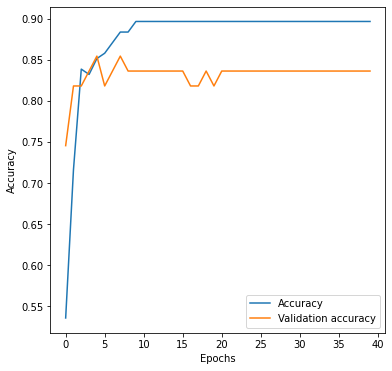

In [17]:

trainer.display_history()

In [18]:
print(model)

MLP(
  (hiddens): ModuleList(
    (0): Hidden_layer(
      (linear): Linear(in_features=36, out_features=512, bias=True)
      (relu): ReLU()
    )
    (1): Hidden_layer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (relu): ReLU()
    )
    (2): Hidden_layer(
      (linear): Linear(in_features=512, out_features=512, bias=True)
      (relu): ReLU()
    )
    (3): Hidden_layer(
      (linear): Linear(in_features=512, out_features=4, bias=True)
      (relu): ReLU()
    )
  )
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


In [19]:
trainer.evaluate(test_dataloader)

==== Evaluate ====

Iteration: 52. Loss: 0.13851413130760193. Accuracy: 88.46153846153847. total loss: 7.2014641761779785.


88.46153846153847

==== Evaluate ====

accuracy 88.46153846153847
[2. 2. 1. 1. 2. 1. 1. 2. 1. 1. 2. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2.
 1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2.
 1. 2. 2. 1.] [1. 2. 1. 1. 3. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 2.
 1. 2. 1. 1. 2. 2. 2. 0. 0. 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 2. 1. 2. 1. 3.
 1. 2. 2. 1.]


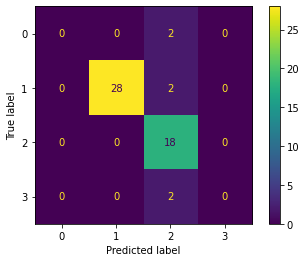

sensitivity : 1.0, specificity : nan, PPV : 1.0, NPV : no negatives values


<ipython-input-6-5b2a7b2f2af9>:35: RuntimeWarning: invalid value encountered in long_scalars
  specificity = TN / (TN + FP)
<ipython-input-6-5b2a7b2f2af9>:39: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN)


88.46153846153847

In [20]:
prediction_analyse(test_dataloader, trainer)

## Only death

In [21]:
covid_dataset_death = CovidDataset(data_path, -5)
train_dataloader_death, val_dataloader_death, test_dataloader_death = create_dataloaders(covid_dataset_death, batch_size=1, split_proportions=split_proportions)

torch.Size([262, 36])


In [22]:
dataset_death = CovidDataset(data_path, -5)

model_death = MLP([36, 512, 512, 512, 2])
#print(model_death)
#print(list(model.parameters()))

trainer_death = Trainer(model_death, dataset_death.class_weights, save_directory, "death_perceptron.pt", loss='BCElogits', lr=0.5)
trainer_death.fit(train_dataloader_death, val_dataloader_death, nb_epochs=nb_epochs)

torch.Size([262, 36])
==== Training ====

Epoch 1 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.2051 - acc: 0.9521 - lr: 0.5000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1715 - acc: 0.9835 - lr: 0.5000
Model saved. Acc updated: -inf -> 0.945
Epoch 2 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.1744 - acc: 0.9772 - lr: 0.5000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1806 - acc: 0.9641 - lr: 0.5000
Epoch 3 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1699 - acc: 0.9862 - lr: 0.5000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1756 - acc: 0.9743 - lr: 0.5000
Epoch 4 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1713 - acc: 0.9833 - lr: 0.5000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1985 - acc: 0.9269 - lr: 0.5000
Epoch 5 / 40
155/155 [==============================] 

155/155 [==============================] - 1s 4ms/step - loss: 0.1832 - acc: 0.9585 - lr: 0.0140
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1961 - acc: 0.9319 - lr: 0.0140
Epoch 39 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.1703 - acc: 0.9853 - lr: 0.0140
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1787 - acc: 0.9678 - lr: 0.0140
Epoch 40 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1760 - acc: 0.9734 - lr: 0.0084
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1751 - acc: 0.9754 - lr: 0.0084


[0.967741935483871, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968, 0.9741935483870968]


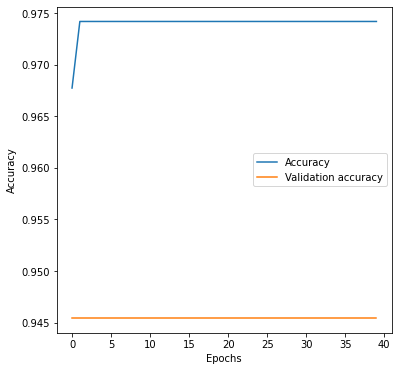

In [23]:
trainer_death.display_history()

In [24]:
trainer_death.evaluate(test_dataloader_death)

==== Evaluate ====

Iteration: 52. Loss: 0.163168266415596. Accuracy: 96.15384615384616. total loss: 9.450206756591797.


96.15384615384616

==== Evaluate ====

accuracy 96.15384615384616
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


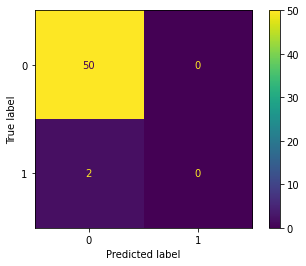

sensitivity : 0.0, specificity : 1.0, PPV : no positives values, NPV : 0.9615384615384616


<ipython-input-6-5b2a7b2f2af9>:37: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)


96.15384615384616

In [25]:
prediction_analyse(test_dataloader_death, trainer_death)

## Only Back Home

In [26]:
covid_dataset_home = CovidDataset(data_path, -4)
train_dataloader_home, val_dataloader_home, test_dataloader_home = create_dataloaders(covid_dataset_home, batch_size=1, split_proportions=split_proportions)

torch.Size([262, 36])


In [27]:
dataset_home = CovidDataset(data_path, -4)

model_home = MLP([36, 512, 512, 512, 2])
#print(model_death)
#print(list(model.parameters()))

trainer_home = Trainer(model_home, dataset_home.class_weights, save_directory, "home_perceptron.pt", loss='BCElogits', lr=0.1)
trainer_home.fit(train_dataloader_home, val_dataloader_home, nb_epochs=nb_epochs)

torch.Size([262, 36])
==== Training ====

Epoch 1 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.3610 - acc: 0.5347 - lr: 0.1000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.3530 - acc: 0.4942 - lr: 0.1000
Model saved. Acc updated: -inf -> 0.400
Epoch 2 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.3468 - acc: 0.8166 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3161 - acc: 0.9333 - lr: 0.1000
Model saved. Acc updated: 0.400 -> 0.945
Epoch 3 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.3098 - acc: 0.9423 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2840 - acc: 0.8822 - lr: 0.1000
Epoch 4 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.2815 - acc: 0.9361 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2722 - acc: 0.9260 - lr: 0.1000
Epoch 5 / 40


155/155 [==============================] - 0s 3ms/step - loss: 0.2596 - acc: 0.9811 - lr: 0.0028
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2595 - acc: 0.9459 - lr: 0.0028
Epoch 39 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.2633 - acc: 0.9616 - lr: 0.0028
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2605 - acc: 0.9595 - lr: 0.0028
Epoch 40 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.2607 - acc: 0.9711 - lr: 0.0017
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2544 - acc: 0.9827 - lr: 0.0017


[0.5741935483870968, 0.8387096774193549, 0.9096774193548387, 0.9290322580645162, 0.9225806451612903, 0.9225806451612903, 0.9290322580645162, 0.9612903225806452, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9612903225806452, 0.9612903225806452, 0.9612903225806452, 0.9548387096774194, 0.9548387096774194, 0.9612903225806452, 0.9612903225806452, 0.9612903225806452, 0.967741935483871, 0.9612903225806452, 0.967741935483871, 0.9612903225806452, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871, 0.967741935483871]


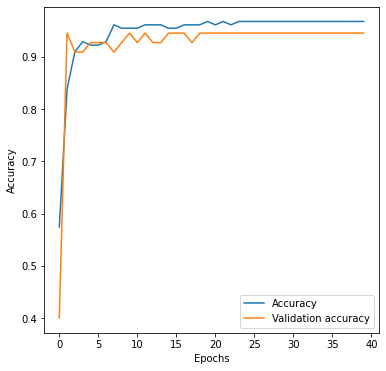

In [28]:
trainer_home.display_history()

In [29]:
trainer_home.evaluate(test_dataloader_home)

==== Evaluate ====

Iteration: 52. Loss: 0.2535320818424225. Accuracy: 98.07692307692308. total loss: 13.44316577911377.


98.07692307692308

==== Evaluate ====

accuracy 98.07692307692308
[0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1.] [0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1.]


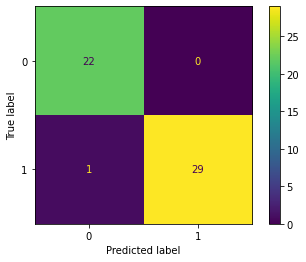

sensitivity : 0.9666666666666667, specificity : 1.0, PPV : 1.0, NPV : 0.9565217391304348


98.07692307692308

In [30]:
prediction_analyse(test_dataloader_home, trainer_home)

## Only Hospilised

In [31]:
covid_dataset_hosp = CovidDataset(data_path, -3)
train_dataloader_hosp, val_dataloader_hosp, test_dataloader_hosp = create_dataloaders(covid_dataset_hosp, batch_size=1, split_proportions=split_proportions)

torch.Size([262, 36])


In [32]:
dataset_hosp = CovidDataset(data_path, -3)

model_hosp = MLP([36, 512, 512, 512, 2])
#print(model_death)
#print(list(model.parameters()))

trainer_hosp = Trainer(model_hosp, dataset_home.class_weights, save_directory, "hosp_perceptron.pt", loss='BCElogits', lr=0.1)
trainer_hosp.fit(train_dataloader_hosp, val_dataloader_hosp, nb_epochs=nb_epochs)

torch.Size([262, 36])
==== Training ====

Epoch 1 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.3622 - acc: 0.4855 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3541 - acc: 0.6842 - lr: 0.1000
Model saved. Acc updated: -inf -> 0.745
Epoch 2 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.3534 - acc: 0.6192 - lr: 0.1000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.3284 - acc: 0.8833 - lr: 0.1000
Model saved. Acc updated: 0.745 -> 0.782
Epoch 3 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.3357 - acc: 0.6949 - lr: 0.1000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.3140 - acc: 0.8393 - lr: 0.1000
Model saved. Acc updated: 0.782 -> 0.818
Epoch 4 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.3094 - acc: 0.8031 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2931

55/55 [==============================] - 0s 2ms/step - loss: 0.2781 - acc: 0.9081 - lr: 0.0028
Epoch 38 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.2684 - acc: 0.9560 - lr: 0.0028
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2874 - acc: 0.8839 - lr: 0.0028
Epoch 39 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.2678 - acc: 0.9618 - lr: 0.0028
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2956 - acc: 0.8427 - lr: 0.0028
Epoch 40 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.2745 - acc: 0.9207 - lr: 0.0017
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.2796 - acc: 0.9036 - lr: 0.0017


[0.6, 0.6, 0.7354838709677419, 0.8, 0.8580645161290322, 0.8903225806451613, 0.8838709677419355, 0.8838709677419355, 0.8838709677419355, 0.8774193548387097, 0.896774193548387, 0.8903225806451613, 0.9032258064516129, 0.9032258064516129, 0.9161290322580645, 0.9225806451612903, 0.9225806451612903, 0.9096774193548387, 0.9290322580645162, 0.9161290322580645, 0.9225806451612903, 0.9225806451612903, 0.9290322580645162, 0.9225806451612903, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9290322580645162, 0.9354838709677419, 0.9290322580645162, 0.9354838709677419, 0.9354838709677419, 0.9354838709677419, 0.9354838709677419, 0.9354838709677419]


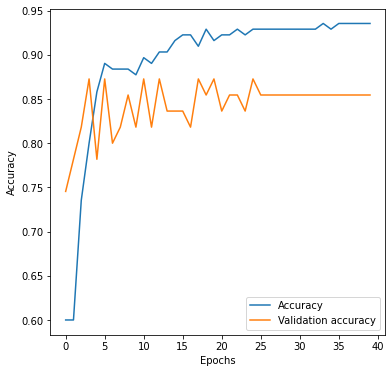

In [33]:
trainer_hosp.display_history()

In [34]:
trainer_hosp.evaluate(test_dataloader_hosp)

==== Evaluate ====

Iteration: 52. Loss: 0.26260361075401306. Accuracy: 94.23076923076923. total loss: 14.17458438873291.


94.23076923076923

==== Evaluate ====

accuracy 94.23076923076923
[0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0.] [0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 0. 0. 0.]


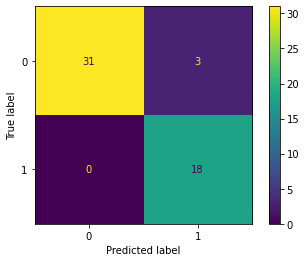

sensitivity : 1.0, specificity : 0.9117647058823529, PPV : 0.8571428571428571, NPV : 1.0


94.23076923076923

In [35]:
prediction_analyse(test_dataloader_hosp, trainer_hosp)

## Only ICU

In [36]:
covid_dataset_icu = CovidDataset(data_path, -2)
train_dataloader_icu, val_dataloader_icu, test_dataloader_icu = create_dataloaders(covid_dataset_icu, batch_size=1, split_proportions=split_proportions)

torch.Size([262, 36])


In [37]:
dataset_icu = CovidDataset(data_path, -2)

model_icu = MLP([36, 512, 512, 512, 2])
#print(model_death)
#print(list(model.parameters()))

trainer_icu = Trainer(model_icu, dataset_icu.class_weights, save_directory, "icu_perceptron.pt", loss='BCElogits', lr=0.1)
trainer_icu.fit(train_dataloader_icu, val_dataloader_icu, nb_epochs=nb_epochs)

torch.Size([262, 36])
==== Training ====

Epoch 1 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.2478 - acc: 0.9298 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1969 - acc: 0.9573 - lr: 0.1000
Model saved. Acc updated: -inf -> 0.964
Epoch 2 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.1946 - acc: 0.9527 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1769 - acc: 0.9785 - lr: 0.1000
Epoch 3 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.1961 - acc: 0.9373 - lr: 0.1000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1908 - acc: 0.9471 - lr: 0.1000
Epoch 4 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.1802 - acc: 0.9688 - lr: 0.1000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1841 - acc: 0.9605 - lr: 0.1000
Epoch 5 / 40
155/155 [==============================] 

155/155 [==============================] - 1s 4ms/step - loss: 0.1983 - acc: 0.9298 - lr: 0.0028
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.1974 - acc: 0.9317 - lr: 0.0028
Epoch 39 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1820 - acc: 0.9639 - lr: 0.0028
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1718 - acc: 0.9853 - lr: 0.0028
Epoch 40 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.1843 - acc: 0.9591 - lr: 0.0017
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.1686 - acc: 0.9920 - lr: 0.0017


[0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194, 0.9548387096774194]


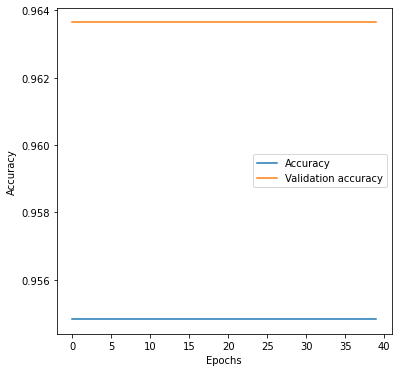

In [38]:
trainer_icu.display_history()

In [39]:
trainer_icu.evaluate(test_dataloader_icu)

==== Evaluate ====

Iteration: 52. Loss: 0.16462524235248566. Accuracy: 96.15384615384616. total loss: 9.52150821685791.


96.15384615384616

==== Evaluate ====

accuracy 96.15384615384616
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


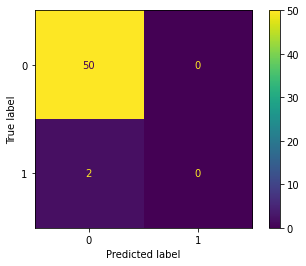

sensitivity : 0.0, specificity : 1.0, PPV : no positives values, NPV : 0.9615384615384616


<ipython-input-6-5b2a7b2f2af9>:37: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)


96.15384615384616

In [40]:
prediction_analyse(test_dataloader_icu, trainer_icu)

## ICU and death

In [41]:
covid_dataset_icu_death = CovidDataset(data_path, -6)
train_dataloader_icu_death, val_dataloader_icu_death, test_dataloader_icu_death = create_dataloaders(covid_dataset_icu_death, batch_size=1, split_proportions=split_proportions)

torch.Size([262, 36])


In [42]:
dataset_icu_death = CovidDataset(data_path, -6)

model_icu_death = MLP([36, 512, 512, 512, 2])
#print(model_death)
#print(list(model.parameters()))

trainer_icu_death = Trainer(model_icu_death, dataset_icu_death.class_weights, save_directory, "icu_death_perceptron.pt", loss='BCElogits', lr=0.5)
trainer_icu_death.fit(train_dataloader_icu_death, val_dataloader_icu_death, nb_epochs=nb_epochs)

torch.Size([262, 36])
==== Training ====

Epoch 1 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.3534 - acc: 0.6110 - lr: 0.5000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3513 - acc: 0.6612 - lr: 0.5000
Model saved. Acc updated: -inf -> 0.745
Epoch 2 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.3562 - acc: 0.5874 - lr: 0.5000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3477 - acc: 0.7146 - lr: 0.5000
Epoch 3 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.3547 - acc: 0.6097 - lr: 0.5000
Validation
55/55 [==============================] - 0s 2ms/step - loss: 0.3494 - acc: 0.6894 - lr: 0.5000
Epoch 4 / 40
155/155 [==============================] - 1s 4ms/step - loss: 0.3557 - acc: 0.5953 - lr: 0.5000
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3408 - acc: 0.8179 - lr: 0.5000
Epoch 5 / 40
155/155 [==============================] 

155/155 [==============================] - 0s 3ms/step - loss: 0.3557 - acc: 0.5948 - lr: 0.0140
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3484 - acc: 0.7049 - lr: 0.0140
Epoch 39 / 40
155/155 [==============================] - 0s 3ms/step - loss: 0.3566 - acc: 0.5817 - lr: 0.0140
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3455 - acc: 0.7477 - lr: 0.0140
Epoch 40 / 40
155/155 [==============================] - 1s 3ms/step - loss: 0.3535 - acc: 0.6272 - lr: 0.0084
Validation
55/55 [==============================] - 0s 1ms/step - loss: 0.3390 - acc: 0.8442 - lr: 0.0084


[0.5806451612903226, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483, 0.5870967741935483]


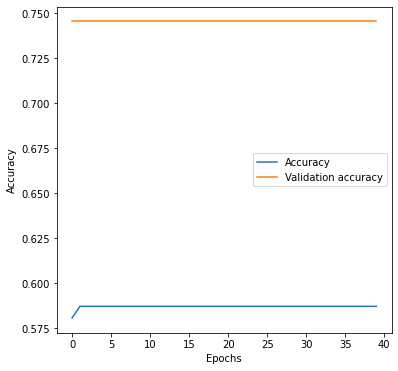

In [43]:
trainer_icu_death.display_history()

In [44]:
trainer_icu_death.evaluate(test_dataloader_icu_death)

==== Evaluate ====

Iteration: 52. Loss: 0.32864153385162354. Accuracy: 65.38461538461539. total loss: 18.29165267944336.


65.38461538461539

==== Evaluate ====

accuracy 65.38461538461539
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.] [0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1.]


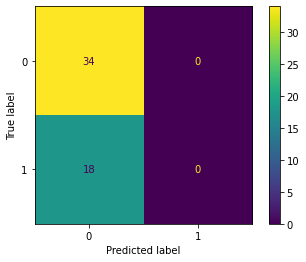

sensitivity : 0.0, specificity : 1.0, PPV : no positives values, NPV : 0.6538461538461539


<ipython-input-6-5b2a7b2f2af9>:37: RuntimeWarning: invalid value encountered in long_scalars
  PPV = TP / (TP + FP)


65.38461538461539

In [45]:
prediction_analyse(test_dataloader_icu_death, trainer_icu_death)

# Agregate all results

## Get all predictions

In [46]:
dataloaders = [test_dataloader, test_dataloader_death, test_dataloader_home, test_dataloader_hosp, test_dataloader_icu, test_dataloader_icu_death]
trainers = [trainer, trainer_death, trainer_home, trainer_hosp, trainer_icu, trainer_icu_death]
all_predictions = []
all_labels = []

for i in range (len(dataloaders)):
    _preds, _labels = get_all_predictions(dataloaders[i], trainers[i])
    all_predictions.append(_preds)
    all_labels.append(_labels)

### Order : 
- all labels at once
- death only
- back home only
- Hospitilization only
- Icu only
- Icu or death 

In [47]:
agregated_preds = np.array([])
for i in range(len(all_predictions[0])):
    res = all_predictions[0][i]
    index = int(all_predictions[0][i])
    if 1 == all_predictions[index + 1][i]:
        agregated_preds = np.append(agregated_preds, all_predictions[0][i])
    elif 1 == all_predictions[-1][i]:
        if 1 == all_predictions[-2][i]:
            agregated_preds = np.append(agregated_preds, all_predictions[-2][i])
        elif 1 == all_predictions[1][i]:
            agregated_preds = np.append(agregated_preds, 0)
        else:
            agregated_preds = np.append(agregated_preds, all_predictions[0][i])
    else:
        agregated_preds = np.append(agregated_preds, all_predictions[0][i])
        
    

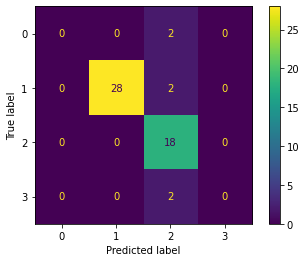

In [48]:
cm = confusion_matrix(all_labels[0], agregated_preds)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()

In [49]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(agregated_preds, all_labels[0])
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(agregated_preds, all_labels[0], average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(agregated_preds, all_labels[0], average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(agregated_preds, all_labels[0], average='weighted')
print('F1 score: %f' % f1)


Accuracy: 0.884615


NameError: name 'precision_score' is not defined

# Test and Save

In [ ]:
test_path = "data/clean_test_data.csv"
df_test = np.loadtxt(test_path, delimiter=",",dtype=float, skiprows=1)

In [ ]:
res = pd.DataFrame(data=df_test[:, 0], columns=["id"])
res["id"] = res["id"].astype(int)
print(df_test.shape)
res

In [ ]:
the_pred = []
model.eval()
df_test = df_test[:,1:]
trainloader = torch.utils.data.DataLoader(df_test, batch_size=1, shuffle=True, num_workers=1)

with torch.no_grad():

    for i, inputs in enumerate(trainloader):

        pred = model(inputs.float())
        label = np.argmax(pred[0].detach().numpy())
        the_pred.append(label)


In [ ]:
print(the_pred)
res['prediction'] = the_pred
res['prediction'].replace({0 : "Death", 1 : "Back home", 2 : 'Hospitalization', 3 : 'Intensive care unit'}, inplace=True)
res.to_csv("prediction_MLP.csv", sep=";", index=False)